# Testing for Control States

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("mode.copy_on_write", True)

In [91]:
opioids = pd.read_csv("data/opioids_clean.csv")
opioids = opioids.copy()
opioids = opioids.drop(columns=["Unnamed: 0"])
opioids

,fips,buyer_county,County,county,state,buyer_state,year,calc_base_wt_in_gm,deaths,population,policy_state,post,prescriptions_per_1000,overdose_per_100k
0,1073,JEFFERSON,"Jefferson County, AL",JEFFERSON COUNTY,ALABAMA,AL,2006,399232.868993,55.0,655893.0,0,0,608.685973,8.385514
1,1073,JEFFERSON,"Jefferson County, AL",JEFFERSON COUNTY,ALABAMA,AL,2007,420555.537846,67.0,655163.0,0,0,641.909781,10.226463
2,1073,JEFFERSON,"Jefferson County, AL",JEFFERSON COUNTY,ALABAMA,AL,2008,440411.156173,63.0,656510.0,0,0,670.836935,9.596198
3,1073,JEFFERSON,"Jefferson County, AL",JEFFERSON COUNTY,ALABAMA,AL,2009,454896.396006,80.0,658441.0,0,0,690.868880,12.149912
4,1073,JEFFERSON,"Jefferson County, AL",JEFFERSON COUNTY,ALABAMA,AL,2010,486677.671546,53.0,658230.0,0,1,739.373276,8.051897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,55133,WAUKESHA,"Waukesha County, WI",WAUKESHA COUNTY,WISCONSIN,WI,2015,200375.123762,34.0,396377.0,0,1,505.516525,8.577692
2620,55133,WAUKESHA,NaN,NaN,NaN,WI,2016,192636.391662,NaN,NaN,0,1,NaN,NaN
2621,55133,WAUKESHA,NaN,NaN,NaN,WI,2017,154116.663589,NaN,NaN,0,1,NaN,NaN
2622,55133,WAUKESHA,NaN,NaN,NaN,WI,2018,126187.189934,NaN,NaN,0,1,NaN,NaN


In [92]:
# exploration
florida_pre = opioids[opioids["state"] == "FLORIDA"]
florida_pre = florida_pre[florida_pre["year"] < 2010]

florida_overdose_pre = florida_pre.groupby("year")["overdose_per_100k"].mean()
florida_prescription_pre = florida_pre.groupby("year")["prescriptions_per_1000"].mean()

print(florida_overdose_pre)
print(florida_prescription_pre)

year
2006    13.193138
2007    14.460052
2008    15.397982
2009    16.606638
Name: overdose_per_100k, dtype: float64
year
2006    545.444669
2007    602.096755
2008    700.332488
2009    816.917153
Name: prescriptions_per_1000, dtype: float64


In [93]:
"""
identify which states are similar to florida pre policy (2010)
"""

TOP_N = 10

threshold1 = 0.10  # 10% of florida's _____-
threshold2 = 0.15
threshold3 = 0.30

pre_2010 = opioids[opioids["year"] < 2010]
states = pre_2010["state"].unique()

# similar avg pop
avg_pop_pre_2010 = pre_2010.groupby("state")["population"].mean()

florida_avg_pop = avg_pop_pre_2010["FLORIDA"]

similar_pop = avg_pop_pre_2010[
    np.abs(avg_pop_pre_2010 - florida_avg_pop) < threshold3 * florida_avg_pop
]

# how florida's values change over years
fl_overdose_change = florida_overdose_pre.diff()
print(fl_overdose_change)
fl_overdose_change = fl_overdose_change.dropna()

fl_prescription_change = florida_prescription_pre.diff()
print(fl_prescription_change)
fl_prescription_change = fl_prescription_change.dropna()

overdose_trend = dict()
prescription_trend = dict()

for state in states:
    if state == "FLORIDA":
        continue

    data = pre_2010[pre_2010["state"] == state]
    data_overdose = data.groupby("year")["overdose_per_100k"].mean()
    data_prescription = data.groupby("year")["prescriptions_per_1000"].mean()

    # compute that state's slope differences
    state_overdose_change = data_overdose.diff().dropna()
    state_prescription_change = data_prescription.diff().dropna()

    overdose_trend[state] = np.sum(np.abs(state_overdose_change - fl_overdose_change))
    prescription_trend[state] = np.sum(
        np.abs(state_prescription_change - fl_prescription_change)
    )

# sort the dicts
sorted_overdose_trend = sorted(overdose_trend.items(), key=lambda x: x[1])
sorted_prescription_trend = sorted(prescription_trend.items(), key=lambda x: x[1])

topN_overdose_states = []
topN_prescription_states = []

for i in range(TOP_N):
    # get top n states that have slopes similar to florida
    state_overdose, _ = sorted_overdose_trend[i]
    state_prescription, _ = sorted_prescription_trend[i]

    topN_overdose_states.append(state_overdose)
    topN_prescription_states.append(state_prescription)

print(f"top {TOP_N} states with similar overdose trends: \n{topN_overdose_states}\n")
print(
    f"top {TOP_N} states with similar prescription shipment trends: \n{topN_prescription_states}"
)

# intersection
set(similar_pop.index) & set(topN_overdose_states) & set(topN_prescription_states)

year
2006         NaN
2007    1.266914
2008    0.937930
2009    1.208656
Name: overdose_per_100k, dtype: float64
year
2006           NaN
2007     56.652086
2008     98.235732
2009    116.584665
Name: prescriptions_per_1000, dtype: float64
top 10 states with similar overdose trends: 
['UTAH', 'MARYLAND', 'IOWA', 'NEBRASKA', 'PENNSYLVANIA', 'COLORADO', 'CALIFORNIA', 'SOUTH CAROLINA', 'MICHIGAN', 'TENNESSEE']

top 10 states with similar prescription shipment trends: 
['DELAWARE', 'NEW MEXICO', 'OKLAHOMA', 'MICHIGAN', 'PENNSYLVANIA', 'OREGON', 'TENNESSEE', 'NEVADA', 'KENTUCKY', 'OHIO']


{'MICHIGAN', 'PENNSYLVANIA', 'TENNESSEE'}

## Plots

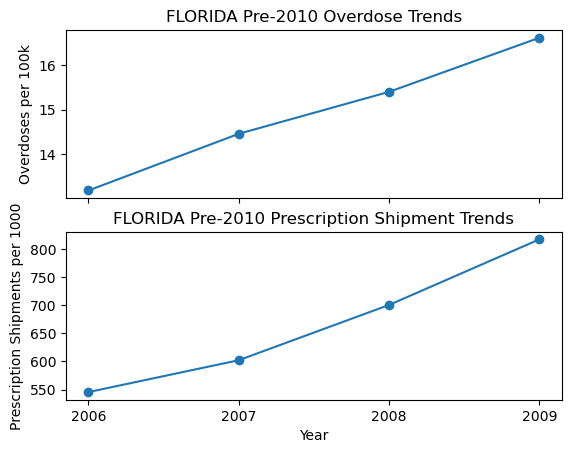

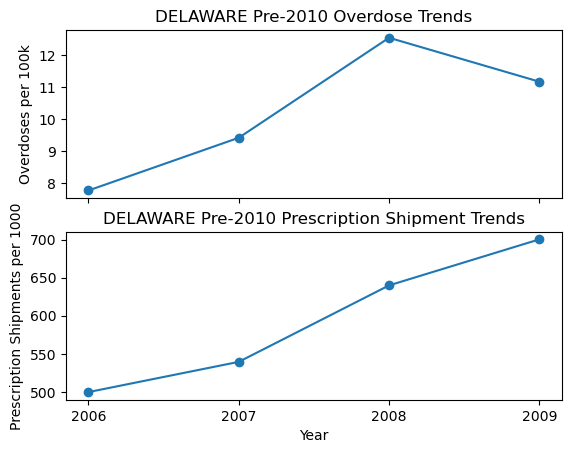

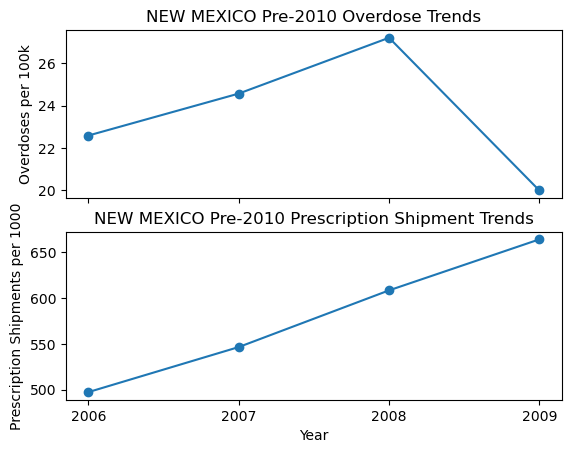

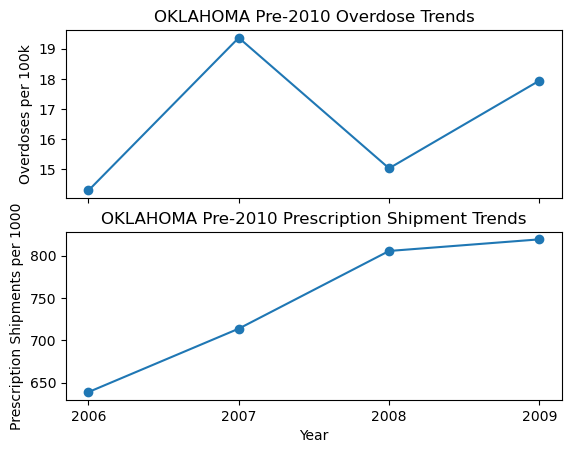

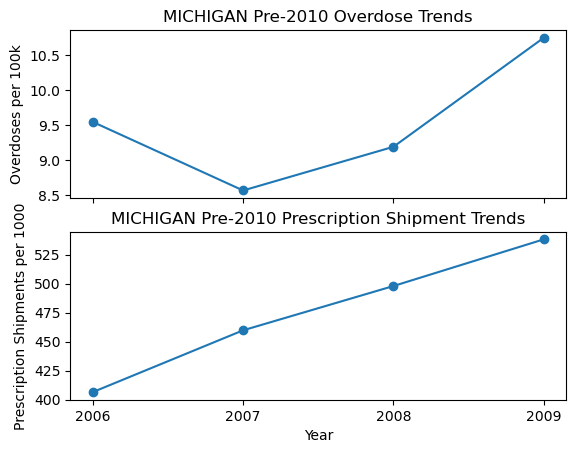

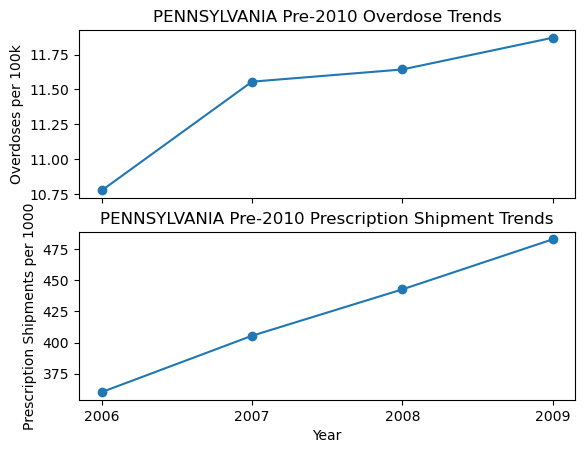

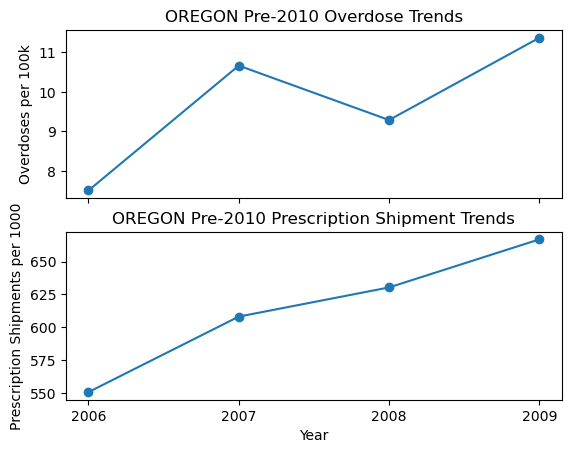

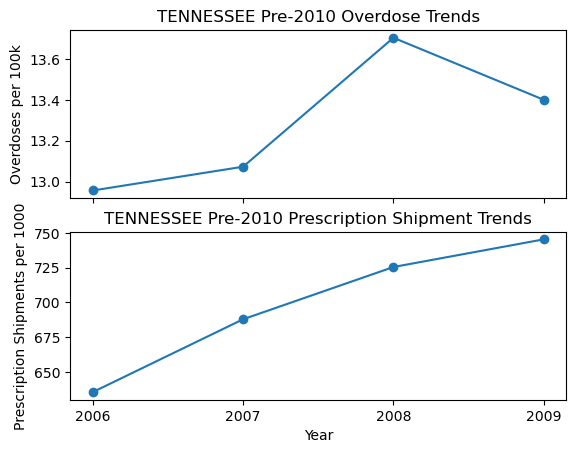

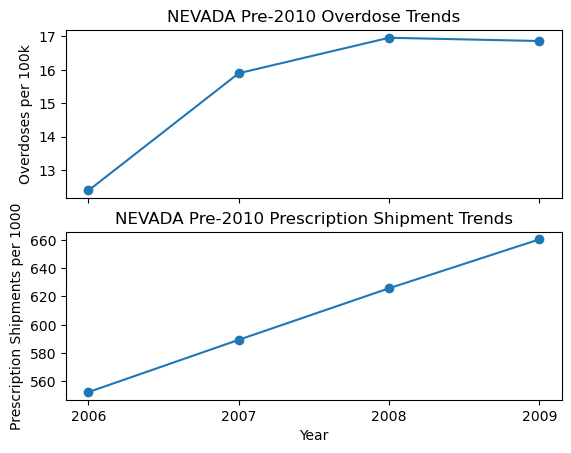

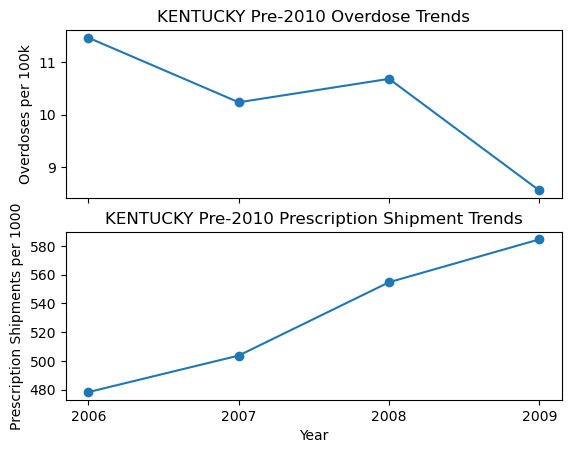

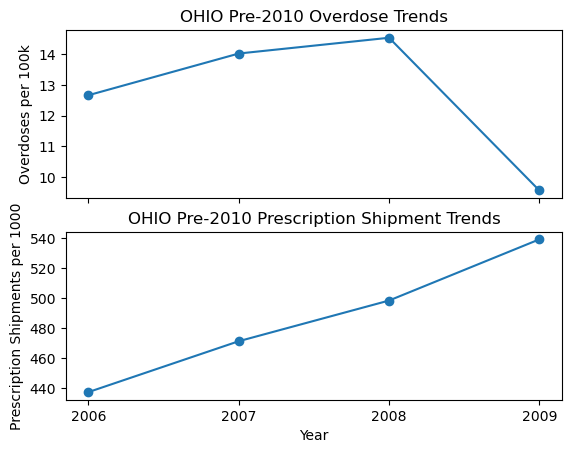

In [ ]:
# similar_states = ["FLORIDA", "MICHIGAN", "PENNSYLVANIA", "TENNESSEE"]

similar_states = [
    # list from top 10 states with similar prescription shipment trends + florida for the loop
    "FLORIDA",
    "DELAWARE",
    "NEW MEXICO",
    "OKLAHOMA",
    "MICHIGAN",
    "PENNSYLVANIA",
    "OREGON",
    "TENNESSEE",
    "NEVADA",
    "KENTUCKY",
    "OHIO",
]


for state in similar_states:
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    data = pre_2010.copy()
    data = data[data["state"] == state]

    data = data.groupby("year")[
        ["population", "overdose_per_100k", "prescriptions_per_1000"]
    ].mean()

    ax1.scatter(data.index, data["overdose_per_100k"])
    ax1.plot(data.index, data["overdose_per_100k"])

    ax2.scatter(data.index, data["prescriptions_per_1000"])
    ax2.plot(data.index, data["prescriptions_per_1000"])

    ax1.set(title=f"{state} Pre-2010 Overdose Trends", ylabel="Overdoses per 100k")
    ax2.set(
        title=f"{state} Pre-2010 Prescription Shipment Trends",
        ylabel="Prescription Shipments per 1000",
        xlabel="Year",
        xticks=data.index.astype(int),
    )

    plt.show()

## Control States

The states who have population, overdose, prescription shipment trends that are simple to those of Florida before 2010 are Michigan, Pennsylvania, Tennessee. Based on the analysis above, they may be reasonable control states. Additional states that may be similar based on similar overdose or prescription shipment trends before 2010 alone can also be found in the output above.